In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.functional import F
from tqdm.notebook import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt

!pip install nilearn
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting


     |████████████████████████████████| 3.1MB 4.5MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
labels = np.load("MyDrive/labels.npy")
tensors = np.load("MyDrive/tensors.npy")
tensors = F.interpolate(torch.Tensor(tensors[:,None]), scale_factor=0.5, mode='trilinear')
ds = TensorDataset(tensors, torch.Tensor(labels)) 

In [ ]:
loader = DataLoader(ds, batch_size=3)

In [ ]:
!nvidia-smi

Wed Mar 24 03:40:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    39W / 300W |   1427MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
cuda = torch.device('cuda:0')

## VAE 


In [ ]:
class VAE(nn.Module):
  def __init__(self, hidden_dim=256, latent_space=64):
    super().__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv3d(1, 256, kernel_size=3, padding=1), # 64,29, 35, 29
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.Conv3d(256, 256, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.MaxPool3d(2), 
        nn.Conv3d(256, 256, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.MaxPool3d(2),
        nn.Conv3d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.MaxPool3d(2), 
        nn.Conv3d(256, 256, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.Conv3d(256, hidden_dim, kernel_size=3, padding=1), #hidden_dim, 3, 4, 3
        nn.AdaptiveAvgPool3d((1, 1, 1)), #hidden_dim, 1, 1, 1
        nn.Flatten() # hidden_dim
    )
    self.encoder_means = nn.Linear(hidden_dim, latent_space)
    self.encoder_stds = nn.Linear(hidden_dim, latent_space)
    
    self.decoder = nn.Sequential(
        nn.Unflatten(1, (latent_space, 1, 1, 1)), 
        nn.Upsample(size=(3, 4, 3), mode='trilinear',), 
        nn.Conv3d(latent_space, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.Upsample(size=(7, 8, 7), mode='trilinear'), 
        nn.Conv3d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.Upsample(size=(14, 17, 14), mode='trilinear'),
        nn.Conv3d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.Upsample(size=(29, 35, 29), mode='trilinear'), 
        nn.Conv3d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.Conv3d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(256),
        nn.Conv3d(256, 1, kernel_size=3, padding=1)
    )

  def encode(self, inputs):
    inputs = self.encoder(inputs)
    means = self.encoder_means(inputs)
    stds = self.encoder_stds(inputs)
    return means, stds
  
  def decode(self, z):
    out = self.decoder(z)
    return out
  
  def sample(self, means, stds):
    epsilon = torch.randn(means.shape).to(device=cuda)
    z = means + epsilon * stds
    return z
  
  def forward(self, inputs):
    means, stds = self.encode(inputs)
    z = self.sample(means, stds)
    out = self.decode(z)
    

    return means, stds, out     

In [ ]:
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.MSELoss()

In [ ]:
model.load_state_dict(torch.load('MyDrive/model_vae_KL08.pth'))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Reconstruction Loss:  4750.68115234375
KL_divergence:  190.73301696777344


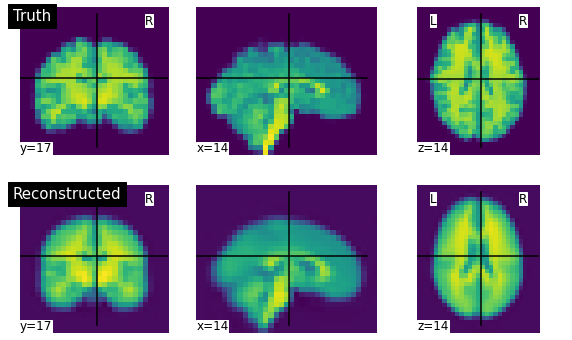

KeyboardInterrupt: ignored

In [ ]:

for e in tqdm(range(100)):
  running_loss = 0
  for i, (X, y) in tqdm(enumerate(loader)):
    X = X.cuda()
    y = y.cuda()
    
    means, stds, outs = model(X)
    
    squared_stds = stds ** 2
    reconstruction_loss = criterion(outs, X)
    KL_divergence = torch.mean(-0.5 * torch.sum(1 + torch.log(squared_stds) - means**2 - squared_stds, dim=1),dim=0)
    KL_divergence = KL_divergence*0.8
    loss = KL_divergence + reconstruction_loss
    running_loss += loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%20 == 0:
      torch.save(model.state_dict(), 'MyDrive/model_vae_KL08_HR.pth')
      #clear_output()
      print('Reconstruction Loss: ', reconstruction_loss.item())
      print('KL_divergence: ', KL_divergence.item())
      affine = np.diag([1, 1, 1, 1])
      t1 = nib.Nifti1Image(X[0][0].detach().cpu().numpy(), affine)
      t2 = nib.Nifti1Image(outs[0][0].detach().cpu().numpy(), affine)
      f = plt.figure(figsize=(10,6))
      ax = plt.subplot(2, 1, 1)
      plotting.plot_img(t1, [s/2 for s in t1.shape], title="Truth", axes=ax)
      ax = plt.subplot(2, 1, 2)
      plotting.plot_img(t2, [s/2 for s in t2.shape], title="Reconstructed", axes=ax)
      # plotting.plot_img(t1,[s/2 for s in t1.shape], title="Truth")
      # plotting.plot_img(t2,[s/2 for s in t2.shape], title="Reconstructed")
      plt.show()
